In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd "drive/My Drive/RedditProect_prev"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/RedditProect_prev


#Imports py

In [0]:

!pip3 install line_profiler
!pip3 install torch-lr-finder 
!pip install essential_generators

In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import torch
from glob import glob
from torch import nn
from torch import optim
from torch.utils import data
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch_lr_finder import LRFinder
from fastai.layers import AdaptiveConcatPool2d,Flatten
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN


from torchvision import  transforms
from torchvision.transforms import ToTensor
from essential_generators import *
import re
import random
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import imageio
import imgaug.augmenters as iaa
from multiprocessing import Pool
import seaborn as sns

class Dataset_ram(data.Dataset):

    def __init__(
        self,
        cats,
        samples,
        normalizer,
        ):

        allprob = 0
        self.samples = samples
        self.normalizer = normalizer
        self.preloader = None
        self.repeat_preloader = False
        self.inpiter = []
        self.probs = []
        self.generators = []
        self.laind = []
        for val in cats:
            allprob += val[0]
            self.probs.append(val[0])
            self.generators.append(val[1])
            self.laind.append(-1)

    def __len__(self):
        '''Denotes the total number of samples'''

        return self.samples

    def __getitem__(self, index):
        '''Generates one sample of data'''

        try:
            return next(self.preloader)
        except:

            if self.repeat_preloader and self.inpiter:
                self.preloader = iter(self.inpiter)
                return next(self.preloader)
            return self.singgen()

    def singgen(self):
        gener = np.random.choice(self.generators, 1, p=self.probs)[0]
        gege = gener.generate_image()
        X = self.normalizer(gege[0])
        y = gege[1]
        return (X, y)

    def pregen(self, size):
        self.inpiter = []
        pd.Series(np.arange(size)).apply(lambda x: self.preappend(x))
        self.preloader = iter(self.inpiter)

    def preappend(self, x):
        if x % 500 == 0:
            print("Generated: "+str(x))
        self.inpiter.append(self.singgen())

    def loop_pregen(self):
        self.repeat_preloader = True

    def unloop_pregen(self):
        self.repeat_preloader = False

    def unplug_pregen(self):

        self.preloader = None
        self.inpiter = []


#!/usr/bin/python
# -*- coding: utf-8 -*-


class ImageGenerator:

    def __init__(
        self,
        path_to_images,
        transformer,
        fonts,
        words_num,
        fon_mul=6e-6,
        split_rn=(0.5, 1),
        from_folder=True,
        diffimages=False,
        cat=0,
        lim=-1,
        ):

        self.diffimages = diffimages
        self.cat = cat

        self.itms = []
        if from_folder:
            il = glob(path_to_images + '*.jpg')
        else:
            il = [path_to_images]

        if lim > 0:
            il = il[:lim]

        self.cut = 0
        with Pool(16) as p:
            self.itms = p.map(self.loadim, il)

    # pd.Series(il).apply(lambda x:self.loadim(x,self.itms))

        self.tfms = transformer
        self.alnum = alnum = list('abcdefghijklmnopqrstuvwxyz1234567890'
                                  )
        self.text_generator = DocumentGenerator()

        self.fons_sz = (30, 40)
        self.fon_mul = fon_mul
        self.spdep = self.lin_dep(self.fons_sz[0] // 2, self.fons_sz[1]
                                  * 2, split_rn[0], split_rn[1])
        self.wddep = self.lin_dep(self.fons_sz[0] // 2, self.fons_sz[1]
                                  * 2, words_num[0], words_num[1])
        self.fonts = []

        for val in fonts:
            self.fonts.append([ImageFont.truetype(val, i) for i in
                              range(self.fons_sz[0] // 2,
                              self.fons_sz[1] * 2)])

    def generate_image(
        self,
        num_words=4,
        one_style=False,
        fonts=False,
        fonts_tp=False,
        filcol=False,
        ):

        y = random.randint(0, len(self.itms) - 1)
        rand = self.itms[y]
        arr = self.tfms(images=[rand])[0]
        pilmg = Image.fromarray(arr)
        pil_draw = ImageDraw.Draw(pilmg)

        if not fonts:
            fonts = int(np.random.randint(self.fons_sz[0],
                        self.fons_sz[1]) - self.fons_sz[0] // 2)
        if not fonts_tp:
            font_tp = np.random.randint(4)
        if not filcol:
            filcol = (np.random.randint(255), np.random.randint(255),
                      np.random.randint(255))

        im_size = pilmg.size
        im_s = im_size[0] * im_size[1]
        holders = []
        for val in range(num_words):

            num_fonts = len(self.fonts[0])
            if not one_style:
                fonts = int(np.random.randint(self.fons_sz[0],
                            self.fons_sz[1]) - self.fons_sz[0] // 2)
                font_tp = np.random.randint(4)
                filcol = (np.random.randint(255),
                          np.random.randint(255),
                          np.random.randint(255))

            idfont = np.clip(int(fonts * im_s * self.fon_mul), 0,
                             num_fonts - 1)
            szfont = idfont + self.fons_sz[0]
            wnum = int(self.wddep[0] * szfont + self.wddep[1])
            spprob = self.spdep[0] * szfont + self.spdep[1]

            gened = self.gen_text(wnum, spprob)
            font = self.fonts[font_tp][idfont]

            text_size = pil_draw.multiline_textsize(gened, font=font)
            (xp1, yp1) = self.rand_placer(im_size, text_size, holders)
            if xp1 == 'burgh':
                break
            align = random.choice(['left', 'center', 'right'])
            pil_draw.text((xp1, yp1), gened, fill=filcol, font=font,
                          align=align)
            holders.append((xp1, text_size[0] + 20, yp1, text_size[1]
                           + 20))

        if self.diffimages:
            return (pilmg, y + self.cat)
        else:
            return (pilmg, self.cat)

    def rand_placer(
        self,
        im_size,
        text_size,
        holders,
        ):
        x_var = np.arange(0, im_size[0] - text_size[0])
        while True:
            if x_var.size == 0:
                return ('burgh', 'burgh')
            x_pos = np.random.choice(x_var)
            space = np.arange(0, im_size[1] - text_size[1])

            for val in holders:
                fillzone_beg = val[0] - text_size[0]
                fillzone_end = val[0] + val[1]
                if fillzone_beg <= x_pos <= fillzone_end:

                    sprange = np.arange(val[2] - text_size[1], val[2]
                            + val[3])
                    space = space[~np.isin(space, sprange)]
                    if space.size == 0:
                        x_var = x_var[~np.isin(x_var,
                                np.arange(fillzone_beg, fillzone_end))]
                        break
            if space.size > 0:
                y_pos = random.choice(space)
                return (x_pos, y_pos)

    def liner(self, line, rate):
        line = list(line.split())
        bdpr = 0
        for (ind, val) in enumerate(line[:-1]):
            if np.tanh(bdpr) > 0.7 + np.random.uniform(0, 0.25):
                line[ind] = line[ind] + '\n'
                bdpr = 0
            else:
                line[ind] = line[ind] + ' '
            bdpr += rate * len(val)
        return ''.join(line)

    def rep_chars(
        self,
        inpute,
        replacement,
        alnum,
        ):
        newChars = map(lambda x: (x if x in alnum else replacement),
                       inpute)
        return re.sub(' +', ' ', ''.join(newChars))

    def gen_text(self, wordnum, spprob):
        prc = np.ceil(wordnum * 0.2)
        sent = self.text_generator.gen_sentence(min_words=wordnum
                - prc, max_words=wordnum + prc)
        gened = self.liner(self.rep_chars(sent.lower(), ' ',
                           self.alnum), spprob)
        return gened

    def lin_dep(
        self,
        x1,
        x2,
        y1,
        y2,
        ):
        a = (y1 - y2) / (x1 - x2)
        b = y1 - x1 * a
        return (a, b)

    def loadim(self, x):
        return imageio.imread(x)


def freeze(model, freeze):
    if 1 in freeze:
        for val in (model[0])[:6].parameters():
            val.requires_grad = False
    if 2 in freeze:
        for val in (model[0])[6:].parameters():
            val.requires_grad = False
    if 3 in freeze:
        for val in model[1:]:
            for par in val.parameters():
                par.requires_grad = False


def unfreeze(model):
    for val in model[0].parameters():
        val.requires_grad = True
    for val in model[1:]:
        for par in val.parameters():
            par.requires_grad = True

def train_cat(
    model,
    pram_groups,
    max_lr,
    steps,
    loader,
    ):

    optimizer = optim.Adam(pram_groups, lr=0.0000001)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
            steps_per_epoch=steps + 1, epochs=1)
    criterion = nn.CrossEntropyLoss()

    dataiter = iter(loader)
    model.cuda()
    model.train()
    con = 0
    running_loss = 0.0
    for val in range(steps):
        (inputs, labls) = dataiter.next()
        con += 1

        inputs = inputs.cuda()
        labls = labls.cuda()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labls)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if con % 5 == 0:
            print("Loss: "+str(loss.item()))

def lr_find(
    model,
    pram_groups,
    loader,
    optimizer,
    ):

    criterion = nn.CrossEntropyLoss()

    lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
    lr_finder.range_test(loader, end_lr=1000, num_iter=100)
    lr_finder.plot()
    lr_finder.reset()

def to_probs(gens, prob):
    res = []
    for val in gens:
        res.append((prob, val))
    return res

def addoutput(model, add):
    outputs = model[9].out_features + add
    old_out = model[9].out_features

    bias = True

    newl = nn.Linear(in_features=model[9].in_features,
                     out_features=outputs, bias=bias)
    lay = model[9]
    newl.weight[:old_out] = lay.weight
    newl.bias[:old_out] = lay.bias
    newl.weight = nn.Parameter(newl.weight)
    newl.bias = nn.Parameter(newl.bias)

    model[-2] = newl
    newb = nn.BatchNorm1d(outputs, eps=model[10].eps,
                          momentum=model[10].momentum,
                          affine=model[10].affine,
                          track_running_stats=model[10].track_running_stats)
    newb.weight.requires_grad = False
    newb.bias.requires_grad = False
    newb.running_mean[:old_out] = model[10].running_mean
    newb.running_var[:old_out] = model[10].running_var
    newb.weight[:old_out] = model[10].weight.data
    newb.bias[:old_out] = model[10].bias.data

    for par in newb.parameters():
        par.requires_grad = True

    model[-1] = newb

def image_load_here(image_path):
    im = Image.open('data/images/' + image_path)
    return normalizer(im)

def predict(model, df, butch_num):

    buthes = np.array_split(df, butch_num)
    model.eval()
    for (key, val) in enumerate(buthes):
        if key % 10 == 0:
            print("Bunches: "+str(key))
        with Pool(16) as p:
            ffef = torch.stack(p.map(image_load_here,
                               buthes[key]['fname']))
        predictions = model(ffef.cuda())
        buthes[key]['type'] = torch.argmax(predictions,
                dim=1).detach().cpu().numpy()
        soft = F.softmax(predictions).detach().cpu().numpy()
        sofes = np.array([soft[key, val] for (key, val) in
                         enumerate(buthes[key]['type'])])
        buthes[key]['prob'] = sofes
        ffef.cpu()
        predictions.cpu()
        del ffef
        del predictions

    return pd.concat(buthes)

def plots_cat(
    val,
    perclass,
    size,
    df,
    tresh,
    ):
    (fig, axbo) = plt.subplots(perclass + 1, 1, figsize=(size, perclass
                               * size))
    tt = df[np.logical_and(df['type'] == val, df['prob']
            > tresh)].sort_values(by=['prob']).head(perclass)
    axbo[0].axis('off')
    axbo[0].text(x=0.5, y=0, s=tt['prob'][0],
                 horizontalalignment='center')
    ks = 1
    for (key, ser) in tt.iterrows():
        img = Image.open('data/images/' + ser['fname'])
        axbo[ks].imshow(img)
        ks += 1
    plt.show()

def dists(classes, size, df):
    gs_kw = dict(height_ratios=[1, 1.5])
    (fig, axbo) = plt.subplots(2, classes[1] - classes[0],
                               figsize=((classes[1] - classes[0])
                               * size, 2.5 * size), gridspec_kw=gs_kw)
    for val in range(classes[0], classes[1]):
        tt = df[df['type'] == val]
        fnmae = tt.sort_values(by=['prob']).iloc[-1, :]['fname']
        img = Image.open('data/images/' + fnmae)
        axbo[0][val - classes[0]].imshow(img)
        axbo[0][val - classes[0]].axis('off')

        sns.violinplot(x='prob', data=tt, ax=axbo[1][val - classes[0]],
                       orient='v')
        axbo[1][val - classes[0]].set_ylim([0, 1])
        axbo[1][val - classes[0]].spines['top'].set_visible(False)
        axbo[1][val - classes[0]].spines['right'].set_visible(False)
        axbo[1][val - classes[0]].spines['bottom'].set_visible(False)
        axbo[1][val - classes[0]].title.set_text(str(val) + ': '
                + str(tt.shape[0]))
    plt.show()

def set_parameters(model):
    pram_groups = [{'params': (model[0])[:6].parameters()},
                   {'params': (model[0])[6:].parameters()},
                   {'params': model[1:].parameters()}]
    return pram_groups

def memes_by_date(memese):
  memese["secs"]=memese["DateTime"].astype('datetime64[s]').astype('int')
  memese.sort_values(by=["secs"],inplace=True)
  chunks = np.array_split(memese, 7)
  time = [chunks[0].iloc[0]["DateTime"][:10]]
  for val in chunks:
    time.append(val.iloc[-1]["DateTime"][:10])

  (fig, ax) = plt.subplots(figsize=(16, 4))
  sns.violinplot(x='secs', data=memese, ax=ax)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.set_xticklabels(['a']+time)
  ax.set_xlabel('')
  ax.set_title('Memes poseted by date', size=20)
  ax.set_xlim([memese["secs"].min(), memese["secs"].max()])
  plt.show()

def top_memes(num,memes):
  fig, axbo = plt.subplots(1, num, figsize=(5*num, 5))
  toplot = memese.sort_values(by=["ups"],ascending=False).head(num)
  ind = 0
  for key,val in toplot.iterrows():
    img=Image.open("data/images/"+val["fname"])
    axbo[ind].imshow(img)
    axbo[ind].axis('off')
    axbo[ind].set_title("Ups: "+str(int(val["ups"])), size=20)
    ind+=1

def real_val(x,probs):
  if(x["prob"]>probs[int(x["type"])]):
    return x["type"]
  else:
    return 0

def fezt_ext(memese,butches):
  fnames = pd.DataFrame(memese[memese["rtype"]==0]["fname"],columns=["fname"]+list(range(1024)))
  buthes = np.array_split(fnames, butches)
  nemmod.eval()
  for (key, val) in enumerate(buthes):
      if key % 10 == 0:
          print("Bunches: "+str(key))
      with Pool(16) as p:
          ffef = torch.stack(p.map(image_load_here,
                              buthes[key]['fname']))
      predictions = nemmod(ffef.cuda())
      buthes[key].iloc[:,1:] = predictions.detach().cpu().data.numpy()
      
      ffef.cpu()
      del ffef
      del predictions
  return pd.concat(buthes)

def pca(mndim,pcaed):
  pca = PCA(n_components=2)
  x = mndim.iloc[:,1:]
  principalComponents = pca.fit_transform(x)
  pcaed[["comp1","comp2"]] = principalComponents
  return pcaed

def plot_cats(pcaed,eps,min_samples,fig):
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)

  pcaed["cluster"] = dbscan.fit_predict(principalComponents)
  pcaedn=pcaed[pcaed["cluster"]>0]

  fig, ax = plt.subplots(1,2,figsize=fig)
  ax[0].scatter(pcaed["comp1"],pcaed["comp2"],c=pcaed["cluster"],cmap="hot")
  ax[0].set_title("Original",fontsize = 15)
  ax[1].scatter(pcaedn["comp1"],pcaedn["comp2"],c=pcaedn["cluster"],cmap="hot")
  ax[1].set_title("No outliers",fontsize = 15)
  plt.show()
  return pcaedn

def plot_top_clusters(cats,top,size,pcaedn,clusters):
  ind = pcaedn.groupby("cluster").count().sort_values(by=["fname"])["fname"]

  fig,ax = plt.subplots(top,cats,figsize=(size[0],size[1]))
  for cat in range(cats):
    inds = clusters[clusters["cluster"]==ind.index[(cat+1)*-1]].index[:top]
    ax[0][cat].set_title("Images: "+str(ind.iloc[(cat+1)*-1]))
    for plc in range(top):
      ax[plc][cat].axis('off')
      im = Image.open("data/images/"+fnames.loc[inds[plc]]["fname"])
      ax[plc][cat].imshow(im)

#Project

# Memes classification project
<div>This project is an classification of memes  scraped from 
<a href="https://www.reddit.com/r/AdviceAnimals/">r/AdviceAnimals</a>
reddit thread by different categories
</div>
<div>Project is made for Vilnius School of AI</div>


#Data

In [0]:
memese = pd.read_csv("memes_fin.csv",index_col=0)

In [0]:
memese.iloc[:,:-2].head(5)

all_awardings  ...              fname
t3_fpy271            []  ...  wqwo5wt098p41.png
t3_fsea88            []  ...  5i6nu0iuu0q41.jpg
t3_fsgyac            []  ...  m2tji14mk1q41.jpg
t3_fskiqh            []  ...  11e5d1srh2q41.jpg
t3_fsl1yz            []  ...  nf6j36bqm2q41.jpg

[5 rows x 14 columns]

In [0]:
print("Number of memes: "+str(memese.shape[0]))

Number of memes: 12576


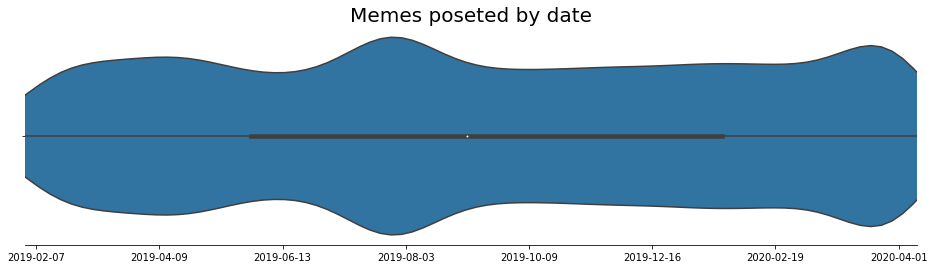

In [0]:
memes_by_date(memese)

**Top 5 mos popular memes:**

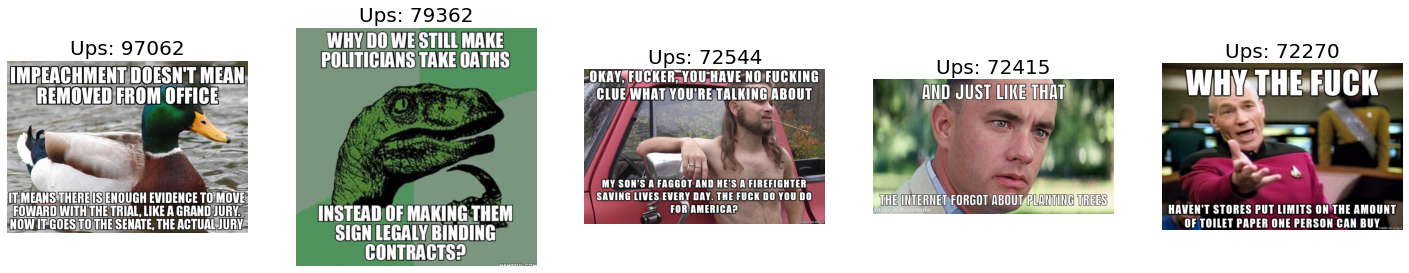

In [0]:
top_memes(5,memese)

#Training Process

Training process for this model is iterative. There is possiblity to add approximately 10 new images on each iteration.

**I use ResNet34:**

In [0]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)
outputs = 20
cmod = nn.Sequential(
    nn.Sequential(*list(model.children())[:-2]),
    nn.Sequential(
      AdaptiveConcatPool2d(1)
    ),
    Flatten(),
    nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.25, inplace=False),
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=outputs, bias=True),
    nn.BatchNorm1d(outputs, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True),
               )
cmod.cuda()
pass

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


First step is to upload chekpoint:

In [0]:
checkpoint = torch.load("NewChekpoints/first20.pth")
cmod.load_state_dict(checkpoint)

<All keys matched successfully>

Then number of outputs for new images should be added:

In [0]:
addoutput(cmod,10)
cmod[10]

BatchNorm1d(30, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)

**Next step is to create generators**

ImgAug transfomers for generators:

In [0]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.3)),
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-90, 90),
        shear=(-8, 8),
        mode='reflect'
    )
], random_order=True) 

seq_cats = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.03)),
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-10, 10),
        mode='reflect'
    )
], random_order=True) 

Fonts for text no generated memes:

In [0]:
fontpath = "data/fonts/"
fonts = [fontpath+"impact.ttf",fontpath+"Montserrat.ttf",fontpath+"ComicSans.ttf",fontpath+"Arial.ttf"]

Generators for an already existing categories:

In [0]:
gens1 = ImageGenerator("Bckup/",seq_cats,fonts,(10,1),4e-6,(0.08,0.15),True,True,1)
gens2 = ImageGenerator("meme2part/",seq_cats,fonts,(10,1),4e-6,(0.08,0.15),True,True,10)

Generator for butch of new images:

In [0]:
gens3 = ImageGenerator("meme3part/",seq_cats,fonts,(10,1),4e-6,(0.08,0.15),True,True,20)

Special generator fot 0 category that represents everething that is not trained yet:

In [0]:
noth_type = ImageGenerator("MemeTypes/imagenetfil/",seq,fonts,(10,1),4e-6,(0.08,0.15))

Then prcentage of images from different generators should be defined
<div></div>
In this example:
<div></div>
0 cat - 10%
<div></div>
already known images - 40%
<div></div>
new images - 50%

In [0]:
gent = [(0.1,noth_type),(0.2,gens1),(0.2,gens2),(0.5,gens3)]

Now I create pytorch dataset from this generators

In [0]:
normalizer = transforms.Compose([
    
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
datagen = Dataset_ram(gent,6400,normalizer)
datagen.pregen(3)
datagen.loop_pregen()

0


**Generator example**

Generators applys ImgAug transformer on clear background image and then writes multiple words on top.

Class: 28


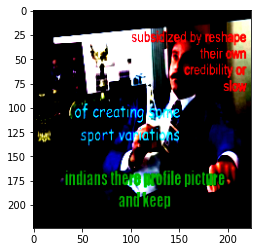

In [0]:
gened = next(iter(datagen))
plt.imshow(gened[0].permute(1,2,0))
print("Class: "+str(gened[1]))

**Train model**

First step is to pregenerate images and store them in ram to use same data in hyperparemeters search and training to save time.

In [0]:
datagen.unplug_pregen()
datagen.pregen(2000)
datagen.loop_pregen()
datagen.samples = 6400000
dataiter = iter(datagen)

Then I freeze all original ResNet34 part of model

In [0]:
freeze(cmod,[1,2])

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



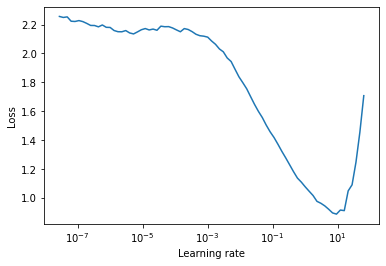

In [0]:
loader = data.DataLoader(dataset = datagen,batch_size=64,pin_memory=True)
parameters = set_parameters(cmod)
optimizer = optim.Adam(parameters, lr=0.000000001)
lr_find(cmod,parameters,loader,optimizer)

In [0]:
train_cat(cmod,parameters,1e-2,50,loader)

Loss: 1.9413615465164185
Loss: 0.9431419968605042
Loss: 0.5817898511886597
Loss: 0.46430864930152893
Loss: 0.366478830575943
Loss: 0.24691426753997803
Loss: 0.34253647923469543
Loss: 0.262766033411026
Loss: 0.179090678691864
Loss: 0.19912247359752655


Now I genrate new data for next step of trainig whith whole ResNet34

In [0]:
datagen.unplug_pregen()
datagen.pregen(2000)
datagen.loop_pregen()
datagen.samples = 6400000
dataiter = iter(datagen)

In [0]:
loader = data.DataLoader(dataset = datagen,batch_size=64,pin_memory=True)

There ResNet is splited in 3 parts so now I should fid LR for each one.


In [0]:
parameters = set_parameters(cmod)
optimizer = optim.Adam(parameters, lr=0.00000000001)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


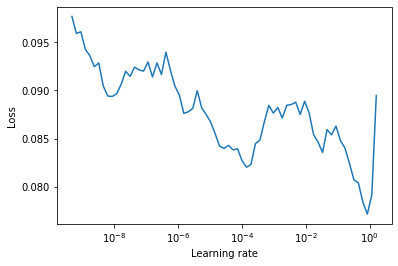

In [0]:
unfreeze(cmod)
freeze(cmod,[1,2])
lr_find(cmod,parameters,loader,optimizer)
unfreeze(cmod)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


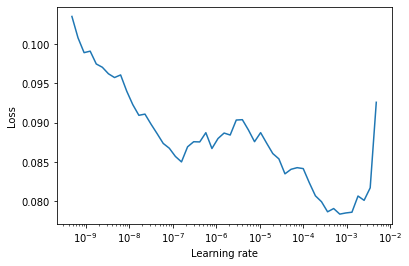

In [0]:
freeze(cmod,[1,3])
lr_find(cmod,parameters,loader,optimizer)
unfreeze(cmod)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


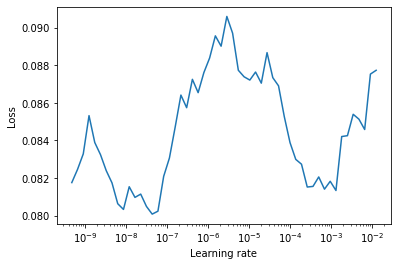

In [0]:
freeze(cmod,[2,3])
lr_find(cmod,parameters,loader,optimizer)
unfreeze(cmod)

In [0]:
train_cat(cmod,parameters,[1e-8,3e-5,1e-2],50,loader)

Loss: 0.08056963235139847
Loss: 0.04859444871544838
Loss: 0.06246845796704292
Loss: 0.10749024152755737
Loss: 0.08889942616224289
Loss: 0.047642678022384644
Loss: 0.048005495220422745
Loss: 0.02917548269033432
Loss: 0.042339690029621124
Loss: 0.0402119904756546


Now it is possible to save model and use it on real data set

In [0]:
torch.save(cmod.state_dict(), "NewChekpoints/first30_ex.pth")
memese = predict(cmod,memese,100)

#Results exploration

Next plot show how images in each category are distributed by SoftMax percentage

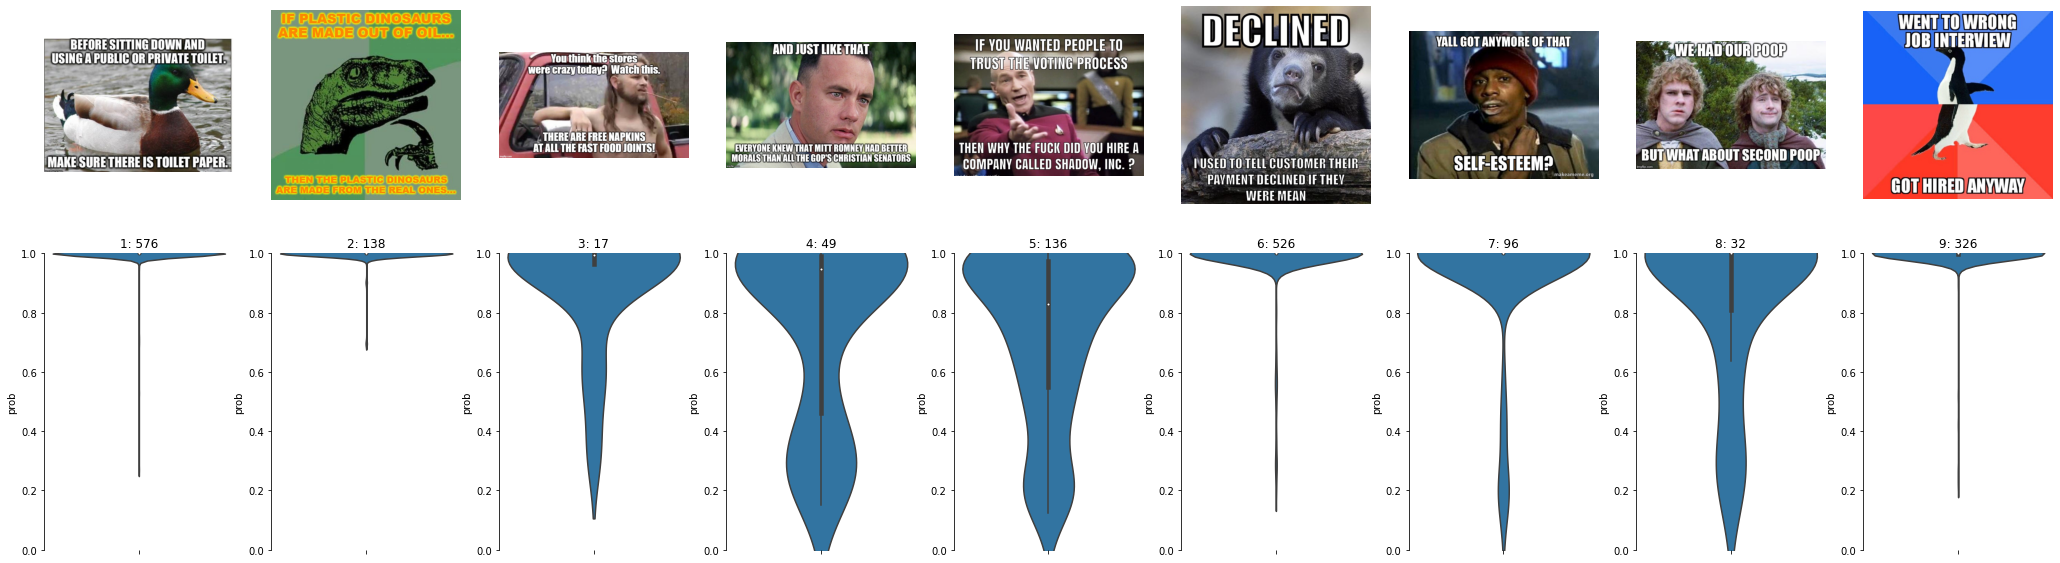

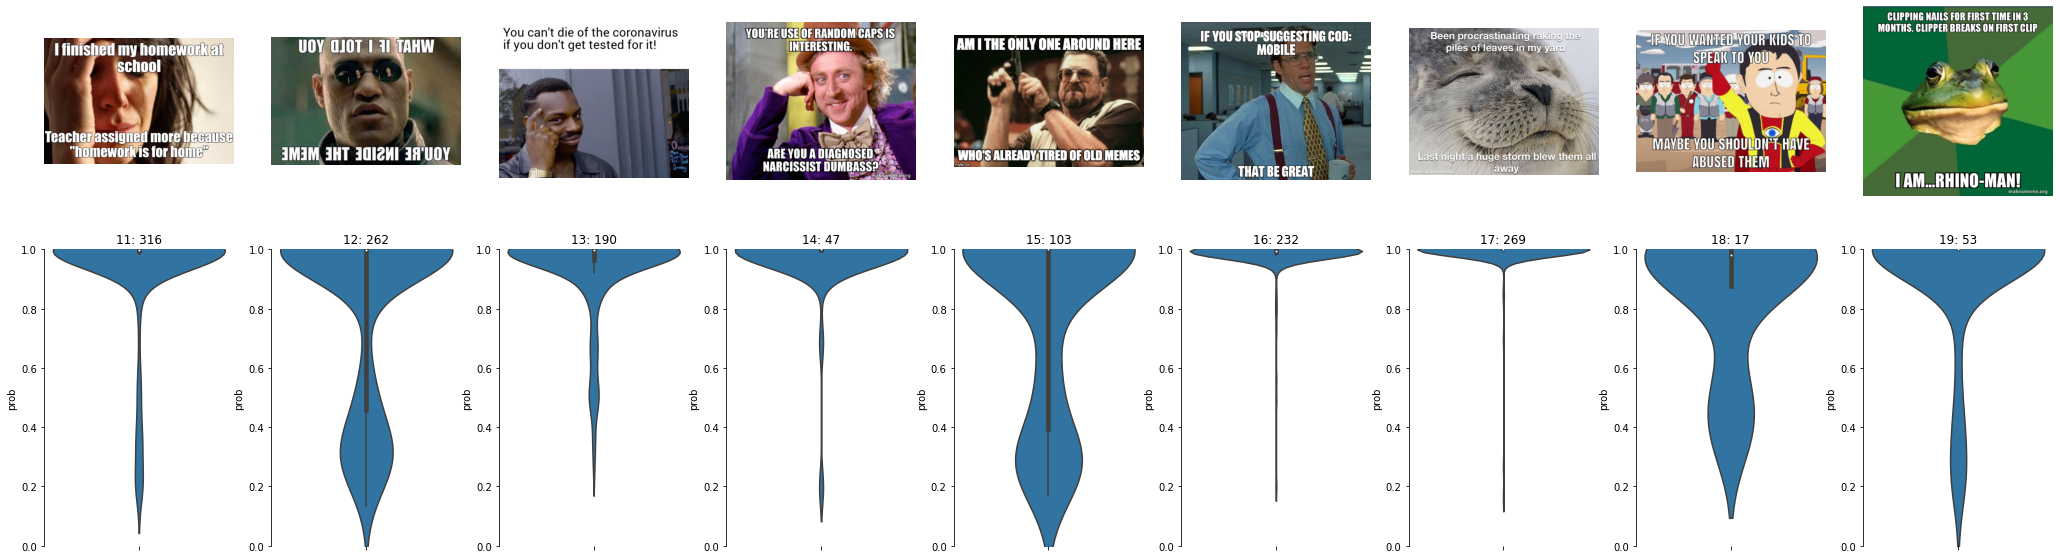

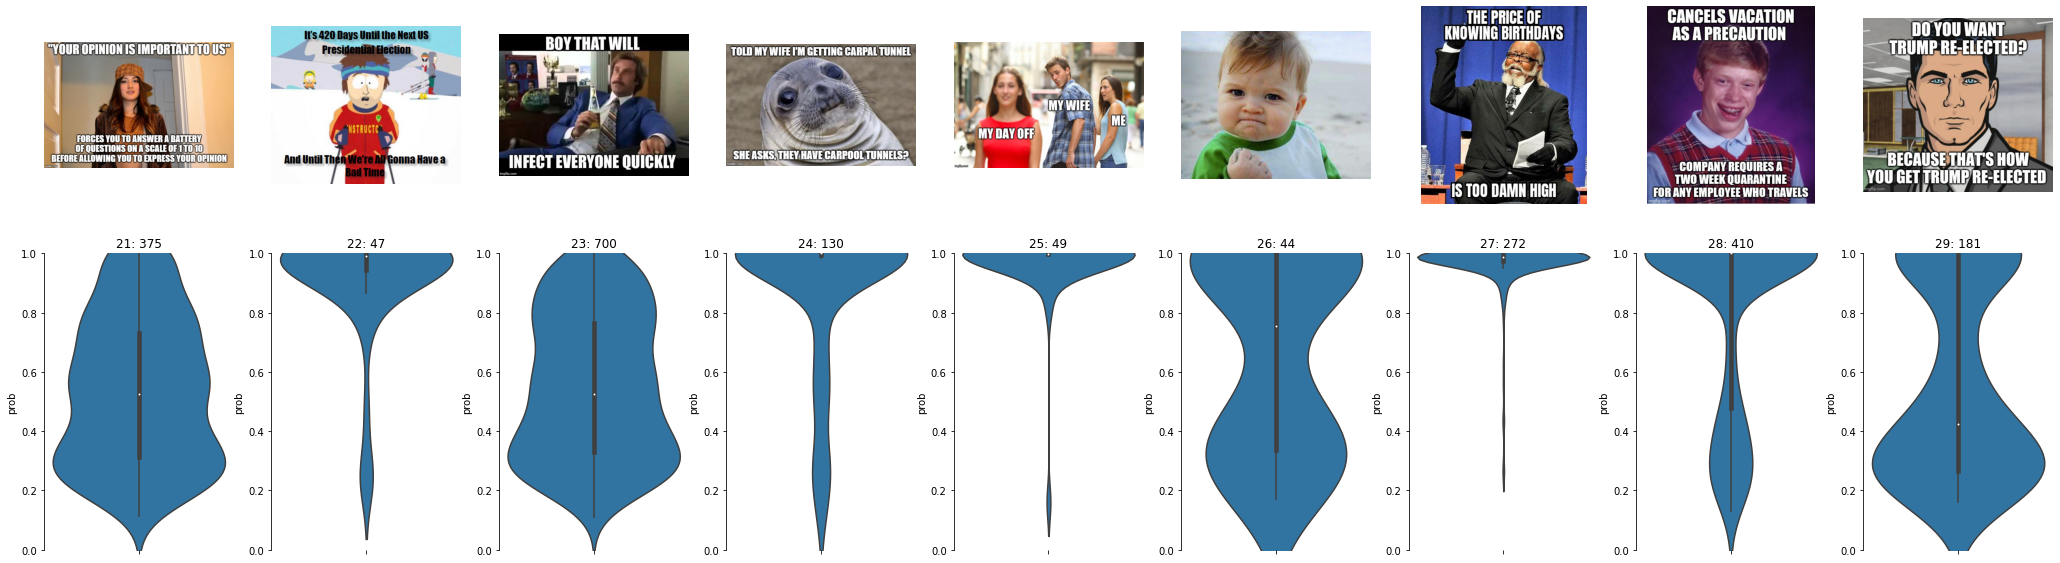

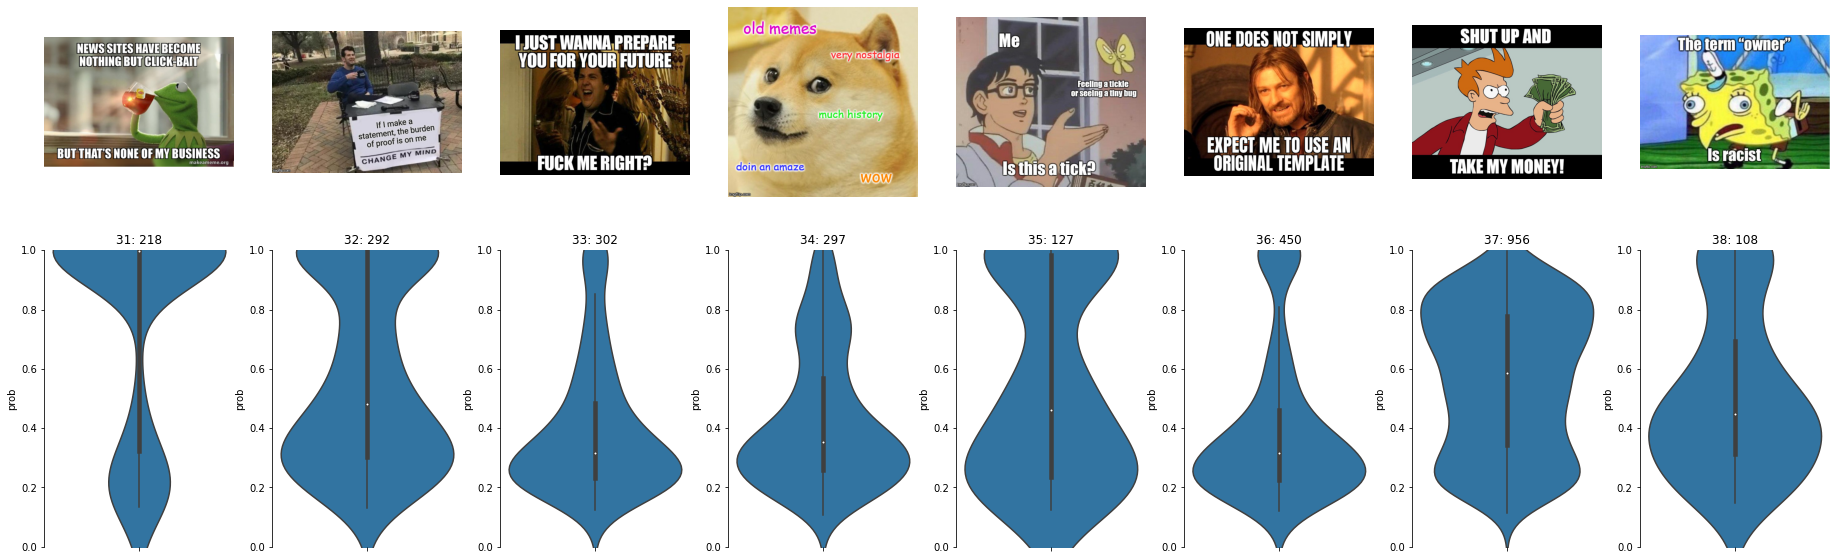

In [0]:
dists((1,10),4,memese)
dists((11,20),4,memese)
dists((21,30),4,memese)
dists((31,39),4,memese)

**Results**<div></div>
Ther is 3 main types of categories:
* Flower(1,9,27) - categroy is well known other images are assigned to other categories
* Bottle neck(12,26,31) - categroy is known but there is group of other images that is assigned to this category with less probability
* Barrel(21,23,37) - there is many other images that are similar to this catategory so there is practically imposible to define a treshold

Next step is to more precisely search for tresholds in some cats and remove Barrel type categories.

This function shows nearest images in category to treshold:

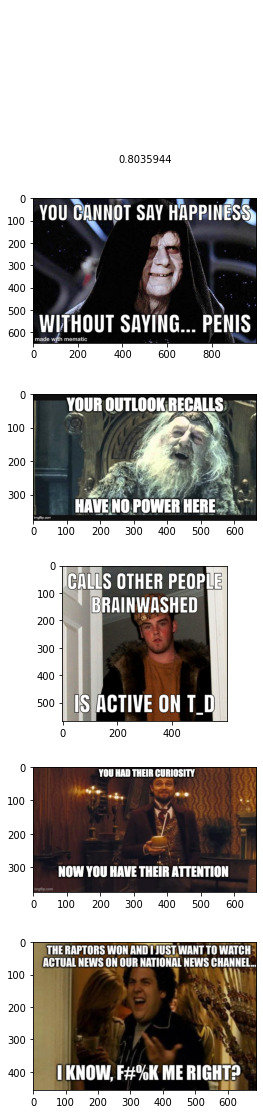

In [0]:
plots_cat(33,5,4,memese,0.8)

For example we can see that class 33 has near treshold wrong images so I make treshold bigger for this class

Base treshold for all classes is 80%

In [0]:
probs = [0.8]*39
probs[0] = 0
probs[4]=0.7
probs[21]=1
probs[23]=1
probs[26]=0.7
probs[33]=0.9
probs[34]=1
probs[37]=1

In [0]:
memese["rtype"] = memese.apply(lambda x:real_val(x,probs),axis=1)

Final df with classes that fit in treshold:

In [0]:
memese.head(5)

all_awardings              author  ...      prob  rtype
t3_fpy271            []         Lino_Albaro  ...  0.996270     30
t3_fsea88            []         jester33455  ...  0.176894      0
t3_fsgyac            []  ClintonWeathershed  ...  0.999993     29
t3_fskiqh            []     disisdawetohell  ...  0.999536      0
t3_fsl1yz            []          burned1000  ...  0.864033      0

[5 rows x 17 columns]

#Clusterization

Clusterization model:

In [0]:
nemmod = nn.Sequential(
    cmod[:2],
    Flatten()
)
nemmod.eval()

In [0]:
mndim = fezt_ext(memese,62)
pcaed = pd.DataFrame(mndim.iloc[:,:1],columns=["fname","comp1","comp2","cluster"])

In [0]:
pcaed = pca(mndim,pcaed)

At this image there are features extracted from pretrained before ResNet34 final Average Pooling layer compresed with PCA and clustered with DBSCAN.

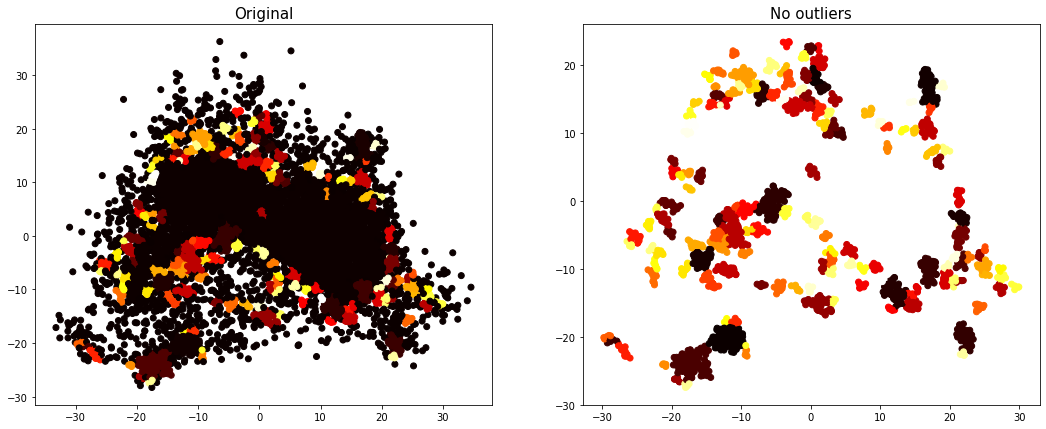

In [0]:
clusters = plot_cats(pcaed,0.6,5,(18,7))

Next there is subsamples of largest clusters

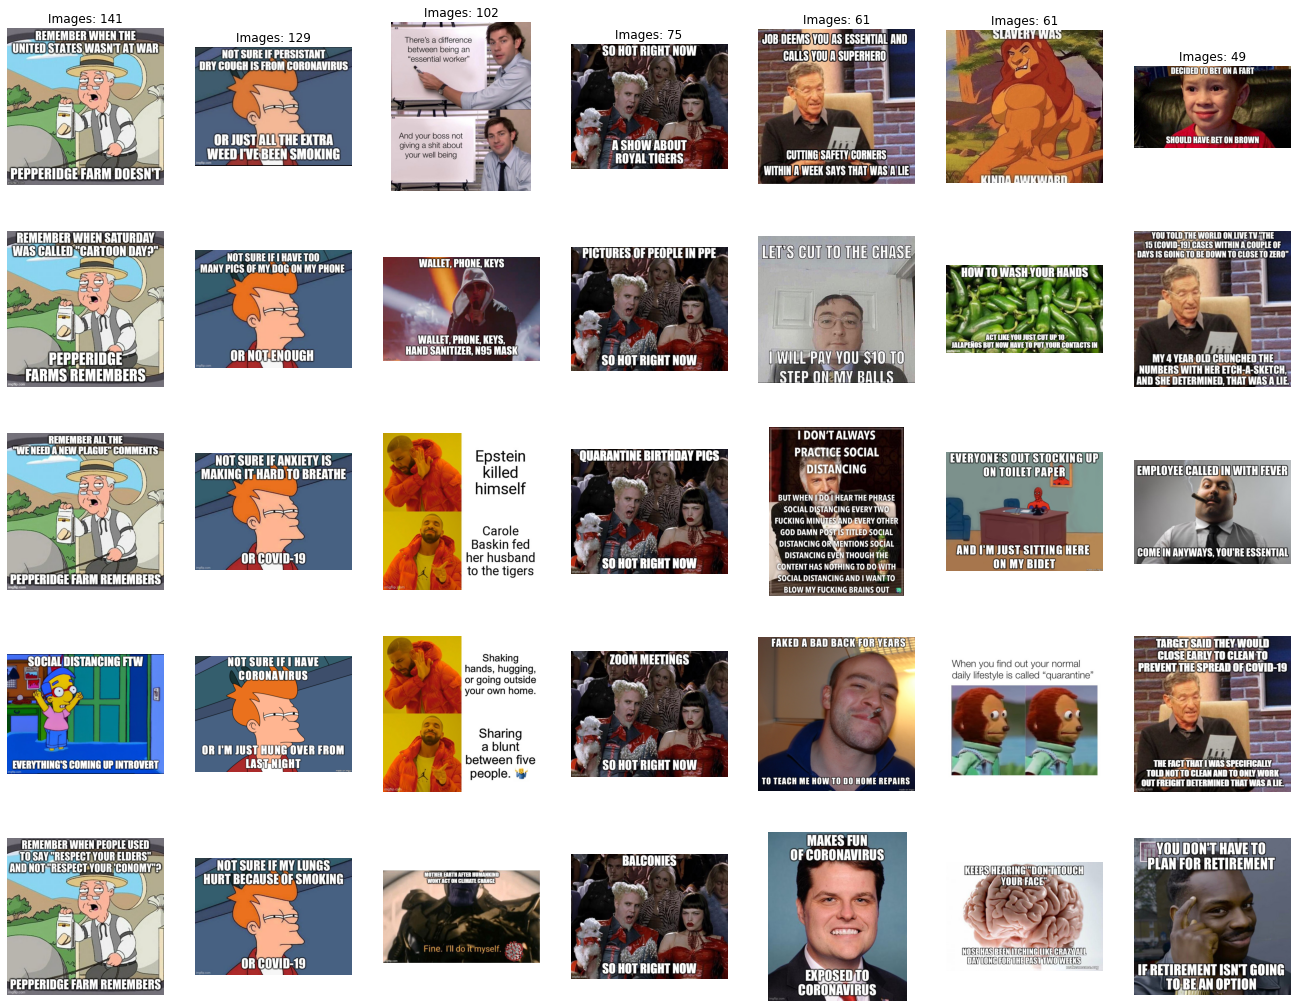

In [0]:
plot_top_clusters(7,5,(23,18),pcaedn,clusters)